In [49]:
import simcronomicon as scon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import os
import copy
from tqdm.notebook import tqdm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import glob
from scipy import stats

In [50]:
# Common parameters
POPULATION_SIZE = 3000
INITIAL_SPREADERS = 30
SIMULATION_DAYS = 120
REPETITIONS = 5  # Run each scenario 5 times for statistical significance
RANDOM_SEED = 42  # For reproducibility

# Set Köln coordinates and radius
KOLN_COORDS = (50.9375, 6.9603)  # Cologne city center
KOLN_RADIUS = 2000  # 3km radius

# Herzogenrath coordinates (for later comparison)
HERZOGENRATH_COORDS = (50.8719, 6.0991)  # Herzogenrath city center
HERZOGENRATH_RADIUS = 2000  # 3km radius

# Create directory for results
import os
os.makedirs("results", exist_ok=True)

In [51]:
# Generate Köln town
print("Generating Köln town...")
koln_params = scon.TownParameters(
    num_pop=POPULATION_SIZE,
    num_init_spreader=INITIAL_SPREADERS
)

koln_town = scon.Town.from_point(
    point=KOLN_COORDS,
    dist=KOLN_RADIUS,
    file_prefix="koln",
    town_params=koln_params,
)

# We'll generate Herzogenrath town later when needed

Generating Köln town...
[1/10] Initializing town object and parameters...
[2/10] Calculating EPSG code...
[3/10] Downloading OSM road network and building data...
[4/10] Processing building geometries...
[5/10] Matching building centroids to nearest road nodes...
[6/10] Classifying buildings...
[7/10] Annotating road graph with place types...
[8/10] Filtering out irrelevant nodes...
[9/10] Building town graph...
Computing shortest paths between filtered nodes...
Adding edges to final town graph...


100%|██████████| 1256/1256 [00:00<00:00, 1381.31it/s]


[10/10] Saving a compressed graph and config_data...
Town graph successfully built and saved!


In [52]:
def run_seir_simulation(town, output_prefix, params, days=SIMULATION_DAYS, seed=None):
    # Create a deep copy of the town to avoid modifying the original
    town_copy = copy.deepcopy(town)
    
    # Create SEIR model
    model = scon.SEIRModel(params)
    
    # Set output file
    output_file = f"{output_prefix}.h5"
    
    # Run simulation
    print(f"Running SEIR simulation: {output_prefix}")
    sim = scon.Simulation(town_copy, model, days, seed_value=seed)
    sim.run(silent=False, hdf5_path=output_file)
    
    return output_file

def run_seiqrdv_simulation(town, output_prefix, params,
                           with_vaccination=True, days=SIMULATION_DAYS, seed=None):
    # Create a deep copy of the town to avoid modifying the original
    town_copy = copy.deepcopy(town)
    
    # Define step events based on enabled features
    step_events = []
    
    # If vaccination is enabled, add vaccination step event
    if with_vaccination:
        step_events.append(
            scon.StepEvent(
                "vaccination_drive",
                scon.FolkSEIQRDV.interact,
                scon.EventType.DISPERSE,
                5000,
                ['accommodation']
            )
        )
    
    # Create SEIQRDV model
    model = scon.SEIQRDVModel(params, step_events)
    
    # Set output file
    output_file = f"{output_prefix}.h5"
    
    # Run simulation
    features = []
    if with_vaccination: features.append("V")
    features_str = "_".join(features) if features else "baseline"
    
    print(f"Running SEIQRDV simulation: {output_prefix} ({features_str})")
    sim = scon.Simulation(town_copy, model, days, seed=True, seed_value=seed)
    sim.run(silent=False, hdf5_path=output_file)
    
    return output_file

def analyze_results(output_file, model_type="SEIR"):
    results = {
        "file": output_file,
        "model": model_type
    }
    
    with h5py.File(output_file, "r") as h5file:
        # Extract status summary data
        summary = h5file["status_summary/summary"][:]
        
        # Get initial population
        if model_type == "SEIR":
            initial_pop = summary[0]["S"] + summary[0]["E"] + summary[0]["I"] + summary[0]["R"]
        else:  # SEIQRDV
            initial_pop = summary[0]["S"] + summary[0]["E"] + summary[0]["I"] + \
                         summary[0]["Q"] + summary[0]["R"] + summary[0]["D"] + summary[0]["V"]
        
        results["population"] = initial_pop
        
        # Track status over time
        status_over_time = {
            "timestep": [row["timestep"] for row in summary],
            "S": [row["S"] for row in summary],
            "E": [row["E"] for row in summary],
            "I": [row["I"] for row in summary],
            "R": [row["R"] for row in summary]
        }
        
        if model_type == "SEIQRDV":
            status_over_time.update({
                "Q": [row["Q"] for row in summary],
                "D": [row["D"] for row in summary],
                "V": [row["V"] for row in summary]
            })
            
        results["status_over_time"] = status_over_time
        
        # Calculate key metrics
        results["peak_infected"] = max(status_over_time["I"])
        results["peak_infected_day"] = status_over_time["timestep"][status_over_time["I"].index(results["peak_infected"])]
        
        # SEIQRDV specific metrics
        if model_type == "SEIQRDV":
            results["total_deaths"] = status_over_time["D"][-1]
            results["death_rate"] = results["total_deaths"] / initial_pop
            results["final_vaccinated"] = status_over_time["V"][-1]
            results["vaccination_coverage"] = results["final_vaccinated"] / initial_pop
            
            # Time to 50% vaccination (if applicable)
            if "V" in status_over_time and max(status_over_time["V"]) > initial_pop * 0.5:
                halfway_point = initial_pop * 0.5
                for t, v in zip(status_over_time["timestep"], status_over_time["V"]):
                    if v >= halfway_point:
                        results["day_50_percent_vaccinated"] = t
                        break
            else:
                results["day_50_percent_vaccinated"] = None
                    
    return results

def plot_comparison(results_list, title, output_file=None):
    # Group results by scenario
    scenarios = {}
    for result in results_list:
        scenario_name = os.path.splitext(os.path.basename(result["file"]))[0]
        scenario_name = "_".join(scenario_name.split("_")[1:-1])
        
        if scenario_name not in scenarios:
            scenarios[scenario_name] = []
        scenarios[scenario_name].append(result)
    
    # Plot setup
    fig, ax = plt.subplots(figsize=(14, 8))
    colors = plt.cm.tab10.colors
    
    # Plot each scenario
    for i, (scenario_name, scenario_results) in enumerate(scenarios.items()):
        # Find the longest time series
        max_time = 0
        for result in scenario_results:
            time_steps = result["status_over_time"]["timestep"]
            max_time = max(max_time, max(time_steps))
        
        # Create a uniform time grid
        time_grid = np.arange(max_time + 1)
        
        # Initialize data arrays
        infected_data = np.zeros((len(scenario_results), len(time_grid)))
        
        # Fill data arrays, calculating total infected based on model type
        for j, result in enumerate(scenario_results):
            time_steps = result["status_over_time"]["timestep"]
            
            # For SEIQRDV model, total infected = I + Q
            # For SEIR model, total infected = I
            if result["model"] == "SEIQRDV":
                infected = [result["status_over_time"]["I"][idx] + result["status_over_time"]["Q"][idx] 
                           for idx in range(len(time_steps))]
                label = f"{scenario_name} (I+Q)"
            else:  # SEIR model
                infected = result["status_over_time"]["I"]
                label = f"{scenario_name} (I)"
            
            # Map data to uniform time grid
            for t, inf in zip(time_steps, infected):
                if t < len(time_grid):
                    infected_data[j, t] = inf
        
        # Calculate mean and confidence intervals
        means = np.mean(infected_data, axis=0)
        
        if len(scenario_results) > 1:
            stdev = np.std(infected_data, axis=0, ddof=1)
            ci95 = stats.t.ppf(0.975, len(scenario_results)-1) * stdev / np.sqrt(len(scenario_results))
            lower = np.maximum(0, means - ci95)
            upper = means + ci95
        else:
            lower = means
            upper = means
        
        # Get the proper label based on model type
        model_type = scenario_results[0]["model"]
        if model_type == "SEIQRDV":
            scenario_label = f"{scenario_name} (I+Q)"
        else:
            scenario_label = f"{scenario_name} (I)"
            
        # Plot with confidence intervals
        ax.plot(time_grid, means, label=scenario_label, color=colors[i % len(colors)], linewidth=2)
        ax.fill_between(time_grid, lower, upper, alpha=0.2, color=colors[i % len(colors)])
    
    # Formatting
    ax.set_xlabel("Days", fontsize=14)
    ax.set_ylabel("Total Infected Individuals", fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=12)
    
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
        print(f"Figure saved to {output_file}")
    
    return fig

def plot_status_over_time(results_list, title, output_file=None, all_statuses=False):
    """
    Plot status counts over time for multiple simulation runs
    
    Parameters:
    -----------
    results_list : list of dict
        List of result dictionaries from analyze_results
    title : str
        Plot title
    output_file : str
        Path to save figure (if None, just displays)
    all_statuses : bool
        Whether to plot all statuses or just infections
    """
    # Ensure all results are from the same scenario
    if len(set([os.path.basename(r["file"]).split("_")[1] for r in results_list])) > 1:
        print("Warning: Results are from different scenarios")
    
    model_type = results_list[0]["model"]
    
    # Define status colors
    colors = {
        "S": "#1E88E5",  # Blue
        "E": "#FFC107",  # Amber
        "I": "#E53935",  # Red
        "R": "#43A047",  # Green
        "Q": "#FB8C00",  # Orange
        "D": "#212121",  # Black
        "V": "#9C27B0"   # Purple
    }
    
    # Determine which statuses to plot
    if all_statuses:
        if model_type == "SEIR":
            statuses = ["S", "E", "I", "R"]
        else:  # SEIQRDV
            statuses = ["S", "E", "I", "Q", "R", "D", "V"]
    else:
        # Just plot infections
        if model_type == "SEIR":
            statuses = ["I"]
        else:  # SEIQRDV
            statuses = ["I", "Q"]
    
    # Find the longest time series
    max_time = 0
    for result in results_list:
        time_steps = result["status_over_time"]["timestep"]
        max_time = max(max_time, max(time_steps))
    
    # Create a uniform time grid
    time_grid = np.arange(max_time + 1)
    
    # Setup plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot each status
    for status in statuses:
        # Initialize data array and valid data counter
        status_data = np.zeros((len(results_list), len(time_grid)))
        valid_counts = np.zeros(len(time_grid))  # Track how many runs have data for each timestep
        
        # Fill data array
        for i, result in enumerate(results_list):
            time_steps = result["status_over_time"]["timestep"]
            values = result["status_over_time"][status]
            
            # Get the maximum timestep for this run
            max_step = max(time_steps)
            
            # Map data to uniform time grid
            for t, val in zip(time_steps, values):
                if t < len(time_grid):
                    status_data[i, t] = val
                    valid_counts[t] += 1
            
            # Mark explicitly which timesteps have valid data
            status_data[i, max_step+1:] = np.nan
        
        # Calculate mean and confidence intervals only where we have valid data
        means = np.zeros(len(time_grid))
        lower = np.zeros(len(time_grid))
        upper = np.zeros(len(time_grid))
        
        for t in range(len(time_grid)):
            # Get non-NaN data for this timestep
            valid_data = status_data[:, t][~np.isnan(status_data[:, t])]
            
            if len(valid_data) > 0:
                means[t] = np.mean(valid_data)
                
                if len(valid_data) > 1:
                    stdev = np.std(valid_data, ddof=1)
                    ci95 = stats.t.ppf(0.975, len(valid_data)-1) * stdev / np.sqrt(len(valid_data))
                    lower[t] = max(0, means[t] - ci95)
                    upper[t] = means[t] + ci95
                else:
                    # Only one valid data point
                    lower[t] = means[t]
                    upper[t] = means[t]
            else:
                # No valid data points
                means[t] = np.nan
                lower[t] = np.nan
                upper[t] = np.nan
        
        # Find the last time step with enough valid data points
        valid_threshold = max(2, len(results_list) // 2)  # At least 2 or half of all runs
        reliable_timesteps = np.where(valid_counts >= valid_threshold)[0]
        
        if len(reliable_timesteps) > 0:
            last_reliable_t = reliable_timesteps[-1]
            # Trim everything after the last reliable timestep
            means = means[:last_reliable_t+1]
            lower = lower[:last_reliable_t+1]
            upper = upper[:last_reliable_t+1]
            plot_time_grid = time_grid[:last_reliable_t+1]
        else:
            plot_time_grid = time_grid
        
        # Plot with confidence intervals
        ax.plot(plot_time_grid, means, label=status, color=colors[status], linewidth=2)
        ax.fill_between(plot_time_grid, lower, upper, alpha=0.2, color=colors[status])
    
    # Formatting
    ax.set_xlabel("Days", fontsize=14)
    ax.set_ylabel("Number of Individuals", fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=12)
    
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
        print(f"Figure saved to {output_file}")
    
    return fig

In [53]:
# SEIR model parameters
seir_params = scon.SEIRModelParameters(
    max_energy=10,    # Maximum energy for each agent
    beta=0.3,         # Transmission probability
    sigma=5,          # Incubation period (days)
    gamma=14,         # Infectious period (days)
    xi=20000 # Very long period
)

# Run SEIR simulations for Köln
seir_results = []

for rep in range(REPETITIONS):
    output_file = run_seir_simulation(
        town=koln_town,
        output_prefix=f"results/koln_seir_rep{rep}",
        params=seir_params,
        seed=RANDOM_SEED + rep
    )
    
    # Analyze results
    results = analyze_results(output_file, model_type="SEIR")
    seir_results.append(results)

Running SEIR simulation: results/koln_seir_rep0
Step has been run 1
Status: {'S': 2958, 'E': 12, 'I': 30, 'R': 0}
Step has been run 2
Status: {'S': 2943, 'E': 27, 'I': 30, 'R': 0}
Step has been run 3
Status: {'S': 2936, 'E': 34, 'I': 30, 'R': 0}
Step has been run 4
Status: {'S': 2922, 'E': 48, 'I': 30, 'R': 0}
Step has been run 5
Status: {'S': 2913, 'E': 45, 'I': 42, 'R': 0}
Step has been run 6
Status: {'S': 2887, 'E': 56, 'I': 57, 'R': 0}
Step has been run 7
Status: {'S': 2853, 'E': 83, 'I': 64, 'R': 0}
Step has been run 8
Status: {'S': 2826, 'E': 96, 'I': 78, 'R': 0}
Step has been run 9
Status: {'S': 2796, 'E': 117, 'I': 87, 'R': 0}
Step has been run 10
Status: {'S': 2762, 'E': 125, 'I': 113, 'R': 0}
Step has been run 11
Status: {'S': 2715, 'E': 138, 'I': 147, 'R': 0}
Step has been run 12
Status: {'S': 2659, 'E': 167, 'I': 174, 'R': 0}
Step has been run 13
Status: {'S': 2598, 'E': 198, 'I': 204, 'R': 0}
Step has been run 14
Status: {'S': 2515, 'E': 247, 'I': 208, 'R': 30}
Step has be

Figure saved to results/koln_seir_status.png


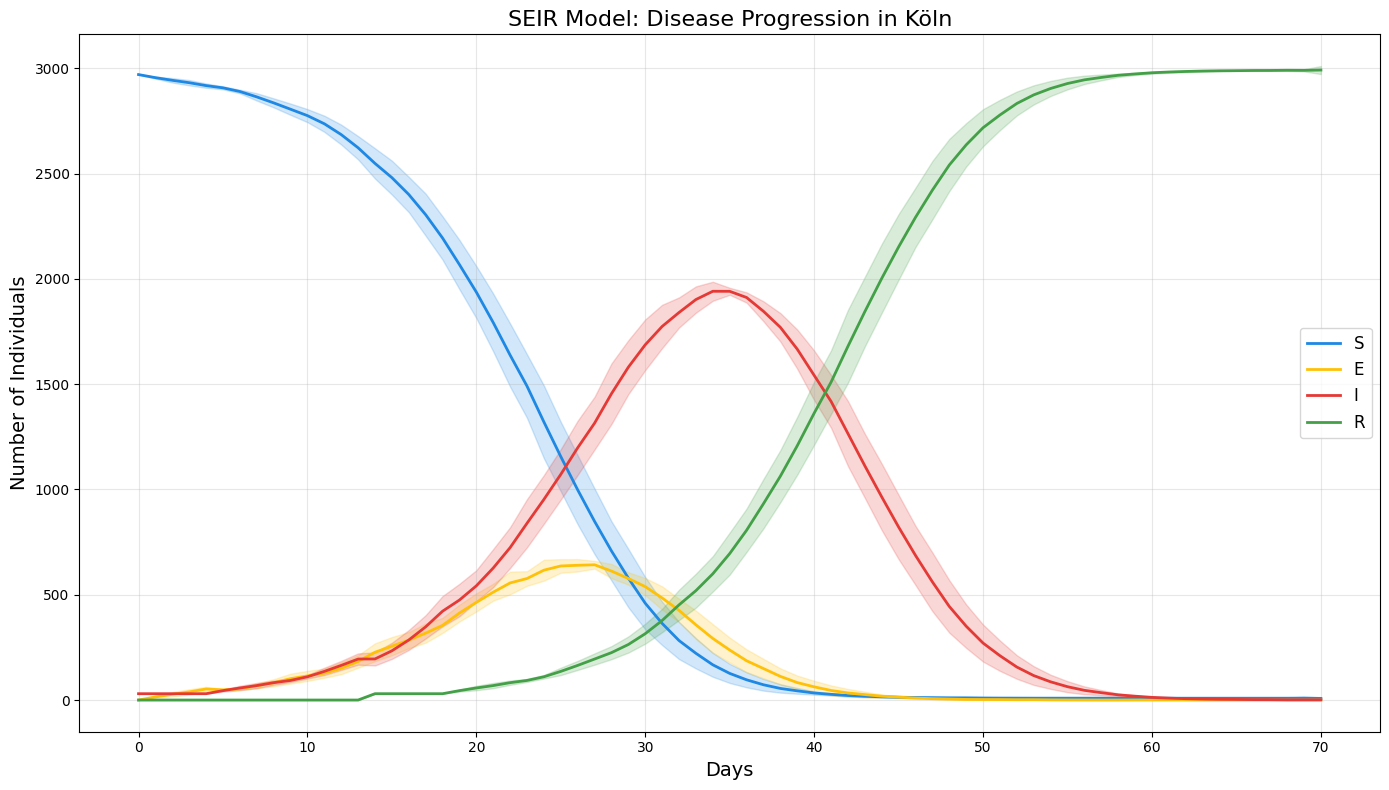

In [54]:
# Plot SEIR results
plot_status_over_time(
    seir_results,
    title="SEIR Model: Disease Progression in Köln",
    output_file="results/koln_seir_status.png",
    all_statuses=True
)

# Calculate and display summary statistics
peak_infected = [r["peak_infected"] for r in seir_results]
peak_day = [r["peak_infected_day"] for r in seir_results]

In [55]:
# SEIQRDV model parameters (without vaccination for now)
seiqrdv_params = scon.SEIQRDVModelParameters(
    max_energy=10,
    lam_cap=0.0,      # No immigration
    beta=0.3,         # Transmission probability
    alpha=0.0,        # No vaccination for now
    gamma=5,          # Incubation duration (days)
    delta=3,          # Days until quarantine
    lam=14,           # Recovery time (days)
    rho=10,           # Time to death (days)
    kappa=0.00,       # Mortality rate (3%)
    mu=0.0,           # No natural deaths
    hospital_capacity=20
)

# Run SEIQRDV simulations without quarantine
seiqrdv_without_q_results = []

for rep in range(REPETITIONS):
    output_file = run_seiqrdv_simulation(
        town=koln_town,
        output_prefix=f"results/koln_seiqrdv_with_q_rep{rep}",
        params=seiqrdv_params,
        with_vaccination=False,
        seed=RANDOM_SEED + rep
    )


Running SEIQRDV simulation: results/koln_seiqrdv_with_q_rep0 (baseline)
Step has been run 1
Status: {'S': 2970, 'E': 0, 'Q': 0, 'I': 30, 'R': 0, 'D': 0, 'V': 0}
Step has been run 2
Status: {'S': 2970, 'E': 0, 'Q': 0, 'I': 30, 'R': 0, 'D': 0, 'V': 0}
Step has been run 3
Status: {'S': 2970, 'E': 0, 'Q': 30, 'I': 0, 'R': 0, 'D': 0, 'V': 0}
Step has been run 4
Status: {'S': 2970, 'E': 0, 'Q': 30, 'I': 0, 'R': 0, 'D': 0, 'V': 0}
Step has been run 5
Status: {'S': 2970, 'E': 0, 'Q': 30, 'I': 0, 'R': 0, 'D': 0, 'V': 0}
Step has been run 6
Status: {'S': 2970, 'E': 0, 'Q': 30, 'I': 0, 'R': 0, 'D': 0, 'V': 0}
Step has been run 7
Status: {'S': 2970, 'E': 0, 'Q': 30, 'I': 0, 'R': 0, 'D': 0, 'V': 0}
Step has been run 8
Status: {'S': 2970, 'E': 0, 'Q': 30, 'I': 0, 'R': 0, 'D': 0, 'V': 0}
Step has been run 9
Status: {'S': 2970, 'E': 0, 'Q': 30, 'I': 0, 'R': 0, 'D': 0, 'V': 0}
Step has been run 10
Status: {'S': 2970, 'E': 0, 'Q': 30, 'I': 0, 'R': 0, 'D': 0, 'V': 0}
Step has been run 11
Status: {'S': 29

In [56]:
# Analyze results
results = analyze_results(output_file, model_type="SEIQRDV")
seiqrdv_without_q_results.append(results)

In [57]:
def plot_seir_vs_seiqrdv_comparison(seir_results, seiqrdv_results, output_file=None):
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Define model styles 
    models = [
        {"name": "SEIR", "results": seir_results, "color": "#1E88E5"},  # Blue
        {"name": "SEIQRDV", "results": seiqrdv_results, "color": "#E53935"}  # Red
    ]
    
    # Find the maximum timestep across all simulations
    max_timestep = 0
    for model in models:
        for result in model["results"]:
            time_steps = result["status_over_time"]["timestep"]
            max_timestep = max(max_timestep, max(time_steps))
    
    # Create a uniform time grid
    time_grid = np.arange(max_timestep + 1)
    
    # Process each model
    for model in models:
        # Initialize arrays for tracking data
        infected_data = np.zeros((len(model["results"]), len(time_grid)))
        valid_counts = np.zeros(len(time_grid))
        
        # Fill infected data array
        for i, result in enumerate(model["results"]):
            time_steps = result["status_over_time"]["timestep"]
            
            # Calculate total infected based on model type
            if model["name"] == "SEIQRDV":
                infected = [result["status_over_time"]["I"][idx] + result["status_over_time"]["Q"][idx] 
                           for idx in range(len(time_steps))]
                label = "SEIQRDV (I+Q)"
            else:  # SEIR model
                infected = result["status_over_time"]["I"]
                label = "SEIR (I only)"
            
            # Mark the last valid timestep for this run
            last_timestep = max(time_steps)
            
            # Fill data and mark valid counts
            for t_idx, t in enumerate(time_steps):
                if t < len(time_grid):
                    infected_data[i, t] = infected[t_idx]
                    valid_counts[t] += 1
            
            # Mark invalid data after simulation end
            infected_data[i, last_timestep+1:] = np.nan
        
        # Calculate statistics where we have valid data
        means = np.zeros(len(time_grid))
        lower = np.zeros(len(time_grid))
        upper = np.zeros(len(time_grid))
        
        for t in range(len(time_grid)):
            # Get valid data for this timestep
            valid_data = infected_data[:, t][~np.isnan(infected_data[:, t])]
            
            if len(valid_data) > 0:
                means[t] = np.mean(valid_data)
                
                if len(valid_data) > 1:
                    stdev = np.std(valid_data, ddof=1)
                    ci95 = stats.t.ppf(0.975, len(valid_data)-1) * stdev / np.sqrt(len(valid_data))
                    lower[t] = max(0, means[t] - ci95)
                    upper[t] = means[t] + ci95
                else:
                    lower[t] = means[t]
                    upper[t] = means[t]
            else:
                means[t] = np.nan
                lower[t] = np.nan
                upper[t] = np.nan
        
        # Find the last time step with enough valid data
        valid_threshold = max(2, len(model["results"]) // 2)  # At least 2 or half of runs
        reliable_timesteps = np.where(valid_counts >= valid_threshold)[0]
        
        if len(reliable_timesteps) > 0:
            last_reliable_t = reliable_timesteps[-1]
            plot_time_grid = time_grid[:last_reliable_t+1]
            plot_means = means[:last_reliable_t+1]
            plot_lower = lower[:last_reliable_t+1]
            plot_upper = upper[:last_reliable_t+1]
        else:
            plot_time_grid = time_grid
            plot_means = means
            plot_lower = lower
            plot_upper = upper
        
        # Generate appropriate label
        if model["name"] == "SEIR":
            model_label = "SEIR (I only)"
        else:
            model_label = "SEIQRDV (I+Q)"
        
        # Plot with confidence intervals
        ax.plot(plot_time_grid, plot_means, 
                label=model_label, 
                color=model["color"], 
                linewidth=2)
        
        ax.fill_between(plot_time_grid, plot_lower, plot_upper, 
                      alpha=0.2, 
                      color=model["color"])
    
    # Add labels and styling
    ax.set_xlabel("Days", fontsize=12)
    ax.set_ylabel("Number of Infected Individuals", fontsize=12)
    ax.set_title("Infection Comparison: SEIR vs SEIQRDV", fontsize=14)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=10)
    
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
        print(f"Figure saved to {output_file}")
    
    return fig

Figure saved to results/koln_seir_vs_seiqrdv_infections.png


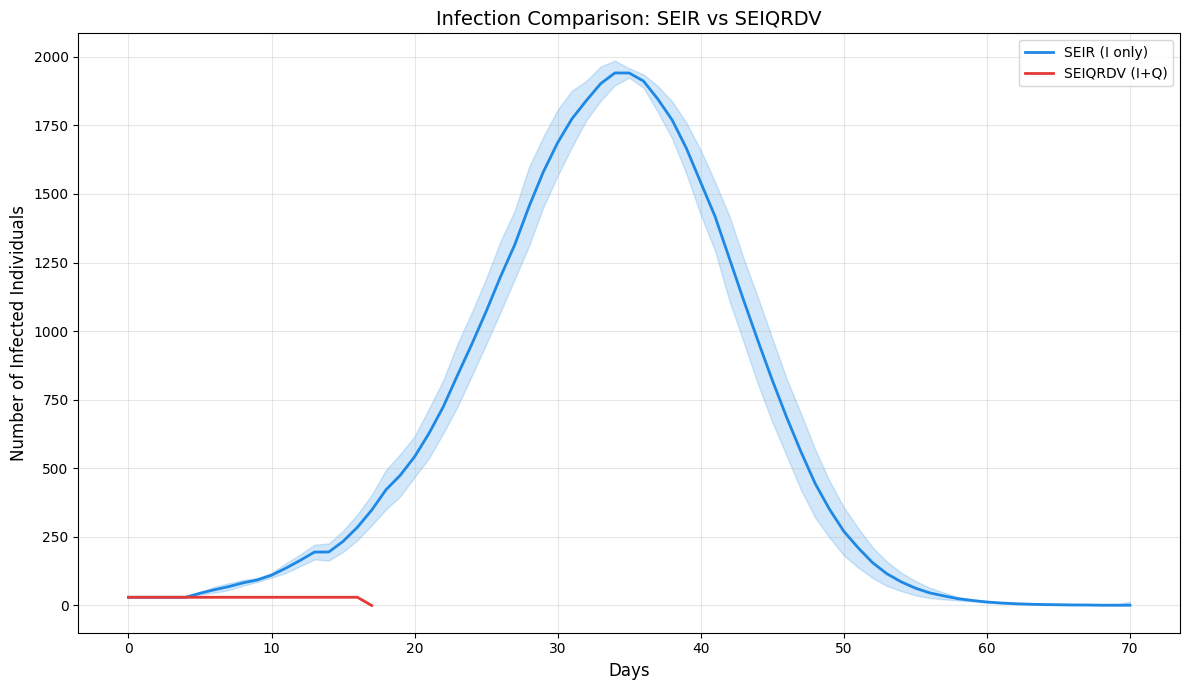

In [58]:
seir_seiqrdv_comparison = plot_seir_vs_seiqrdv_comparison(
    seir_results=seir_results,
    seiqrdv_results=seiqrdv_without_q_results,  # Use the without vaccinations
    output_file="results/koln_seir_vs_seiqrdv_infections.png"
)

In [ ]:
# SEIQRDV model parameters with vaccination
seiqrdv_full_params = scon.SEIQRDVModelParameters(
    max_energy=10,
    lam_cap=0.0,      # No immigration
    beta=0.3,         # Transmission probability
    alpha=0.02,       # 2% daily vaccination rate desire
    gamma=5,          # Incubation duration (days)
    delta=3,          # Days until quarantine
    lam=14,           # Recovery time (days)
    rho=10,           # Time to death (days)
    kappa=0.03,       # Mortality rate (3%)
    mu=0.0,           # No natural deaths
    hospital_capacity=20
)

# Run SEIQRDV simulations with vaccination
seiqrdv_full_results = []

for rep in range(REPETITIONS):
    output_file = run_seiqrdv_simulation(
        town=koln_town,
        output_prefix=f"results/koln_seiqrdv_full_rep{rep}",
        params=seiqrdv_full_params,
        with_vaccination=True,
        seed=RANDOM_SEED + rep
    )
    
    # Analyze results
    results = analyze_results(output_file, model_type="SEIQRDV")
    seiqrdv_full_results.append(results)

Running SEIQRDV simulation: results/koln_seiqrdv_full_rep0 (V)
Step has been run 1
Status: {'S': 2915, 'E': 7, 'Q': 0, 'I': 30, 'R': 0, 'D': 0, 'V': 48}
Step has been run 2
Status: {'S': 2865, 'E': 16, 'Q': 0, 'I': 30, 'R': 0, 'D': 0, 'V': 89}
Step has been run 3
Status: {'S': 2823, 'E': 20, 'Q': 30, 'I': 0, 'R': 0, 'D': 0, 'V': 127}
Step has been run 4
Status: {'S': 2780, 'E': 20, 'Q': 30, 'I': 0, 'R': 0, 'D': 0, 'V': 170}
Step has been run 5
Status: {'S': 2736, 'E': 13, 'Q': 30, 'I': 7, 'R': 0, 'D': 0, 'V': 214}
Step has been run 6
Status: {'S': 2690, 'E': 5, 'Q': 30, 'I': 16, 'R': 0, 'D': 0, 'V': 259}
Step has been run 7
Status: {'S': 2644, 'E': 4, 'Q': 30, 'I': 20, 'R': 0, 'D': 0, 'V': 302}
Step has been run 8
Status: {'S': 2599, 'E': 5, 'Q': 37, 'I': 13, 'R': 0, 'D': 0, 'V': 346}
Step has been run 9
Status: {'S': 2552, 'E': 7, 'Q': 46, 'I': 4, 'R': 0, 'D': 0, 'V': 391}
Step has been run 10
Status: {'S': 2505, 'E': 7, 'Q': 50, 'I': 1, 'R': 0, 'D': 0, 'V': 437}
Step has been run 11


Figure saved to results/koln_seiqrdv_full_status.png

Full SEIQRDV Model Summary (Köln):
Peak Infected: 50.0 ± 0.0
Total Deaths: 2.6 ± 1.5
Final Vaccinated: 456.2 ± 31.6


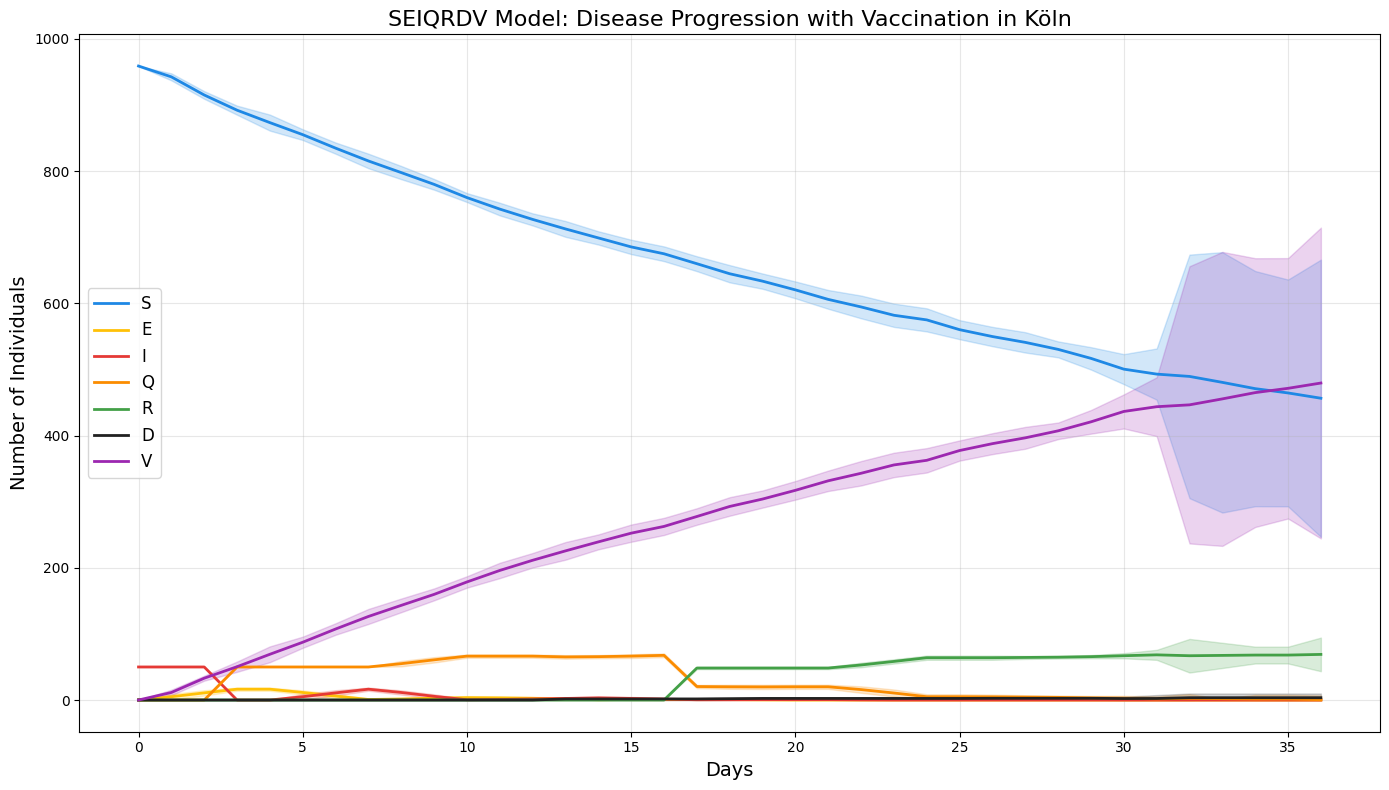

In [ ]:
# Plot full SEIQRDV results
plot_status_over_time(
    seiqrdv_full_results,
    title="SEIQRDV Model: Disease Progression with Vaccination in Köln",
    output_file="results/koln_seiqrdv_full_status.png",
    all_statuses=True
)

# Calculate and display summary statistics
full_peak = [r["peak_infected"] for r in seiqrdv_full_results]
full_deaths = [r["total_deaths"] for r in seiqrdv_full_results]
full_vaccinated = [r["final_vaccinated"] for r in seiqrdv_full_results]

print("\nFull SEIQRDV Model Summary (Köln):")
print(f"Peak Infected: {np.mean(full_peak):.1f} ± {np.std(full_peak):.1f}")
print(f"Total Deaths: {np.mean(full_deaths):.1f} ± {np.std(full_deaths):.1f}")
print(f"Final Vaccinated: {np.mean(full_vaccinated):.1f} ± {np.std(full_vaccinated):.1f}")

Generating Herzogenrath town...
[1/10] Initializing town object and parameters...
[2/10] Calculating EPSG code...
[3/10] Downloading OSM road network and building data...
[4/10] Processing building geometries...
[5/10] Matching building centroids to nearest road nodes...
[6/10] Classifying buildings...
[7/10] Annotating road graph with place types...
[8/10] Filtering out irrelevant nodes...
[9/10] Building town graph...
Computing shortest paths between filtered nodes...
Adding edges to final town graph...


100%|██████████| 360/360 [00:00<00:00, 4538.81it/s]

[10/10] Saving a compressed graph and config_data...


Town graph successfully built and saved!
Running SEIQRDV simulation: results/herzogenrath_seiqrdv_full_rep0 (V)
Step has been run 1
Status: {'S': 937, 'E': 10, 'Q': 0, 'I': 50, 'R': 0, 'D': 0, 'V': 12}
Step has been run 2
Status: {'S': 907, 'E': 20, 'Q': 0, 'I': 50, 'R': 0, 'D': 0, 'V': 32}
Step has been run 3
Status: {'S': 885, 'E': 28, 'Q': 50, 'I': 0, 'R': 0, 'D': 0, 'V': 46}
Step has been run 4
Status: {'S': 867, 'E': 28, 'Q': 50, 'I': 0, 'R': 0, 'D': 0, 'V': 64}
Step has been run 5
Status: {'S': 847, 'E': 18, 'Q': 50, 'I': 10, 'R': 0, 'D': 0, 'V': 84}
Step has been run 6
Status: {'S': 827, 'E': 8, 'Q': 50, 'I': 20, 'R': 0, 'D': 0, 'V': 104}
Step has been run 7
Status: {'S': 803, 'E': 4, 'Q': 50, 'I': 28, 'R': 0, 'D': 0, 'V': 124}
Step has been run 8
Status: {'S': 781, 'E': 6, 'Q': 60, 'I': 18, 'R': 0, 'D': 0, 'V': 144}
Step has been run 9
Status: {'S': 760, 'E': 7, 'Q': 70, 'I': 8, 'R': 0, 'D': 0, 'V': 164}
Step has been run 10
Status: {'S': 749, 'E': 9, 'Q': 78, 'I': 0, 'R': 0, '

TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

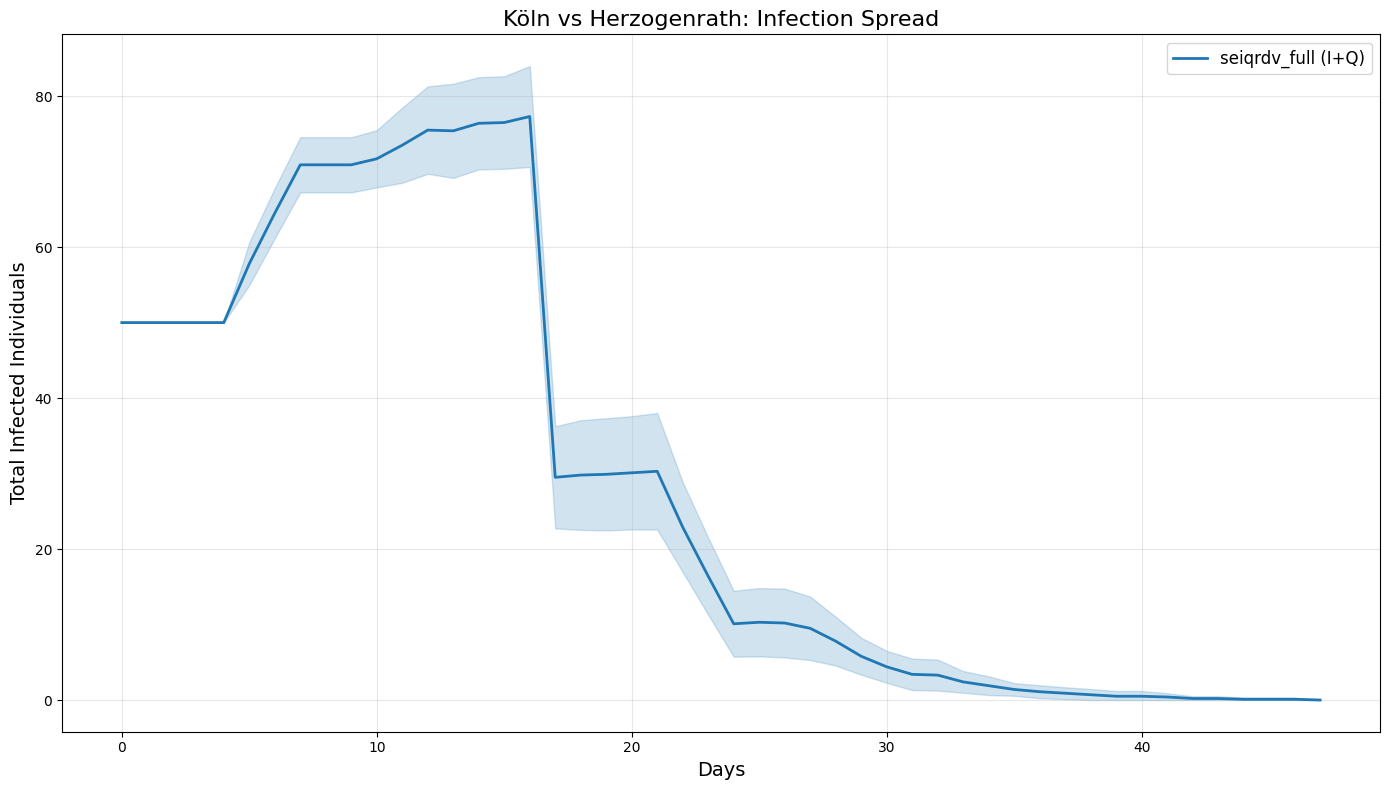

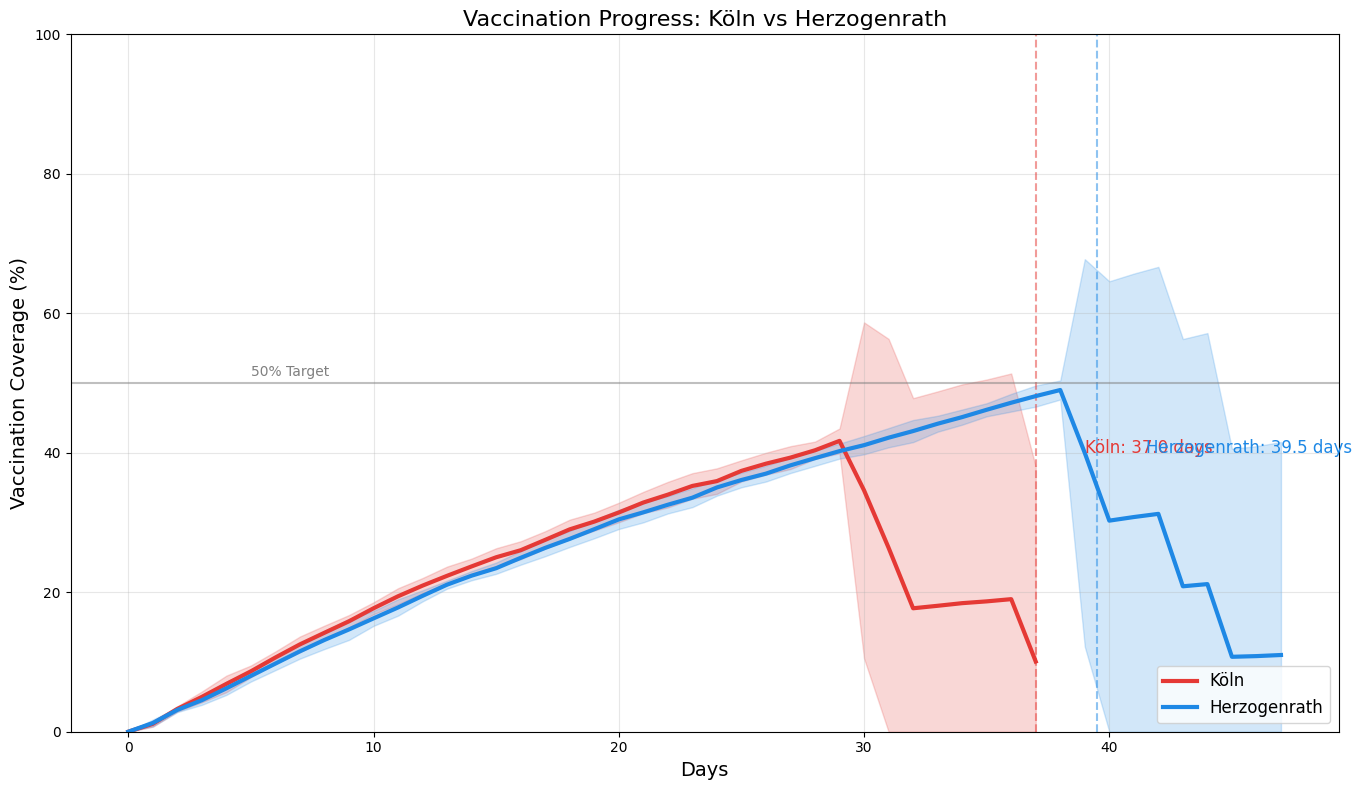

In [ ]:
# Generate Herzogenrath town
print("Generating Herzogenrath town...")
herzogenrath_params = scon.TownParameters(
    num_pop=POPULATION_SIZE,
    num_init_spreader=INITIAL_SPREADERS
)

herzogenrath_town = scon.Town.from_point(
    point=HERZOGENRATH_COORDS,
    dist=HERZOGENRATH_RADIUS,
    town_params=herzogenrath_params, file_prefix="herzogenrath"
)

# Run SEIQRDV simulations for Herzogenrath
seiqrdv_herzogenrath_results = []

for rep in range(REPETITIONS):
    output_file = run_seiqrdv_simulation(
        town=herzogenrath_town,
        output_prefix=f"results/herzogenrath_seiqrdv_full_rep{rep}",
        params=seiqrdv_full_params,
        with_vaccination=True,
        seed=RANDOM_SEED + rep
    )
    
    # Analyze results
    results = analyze_results(output_file, model_type="SEIQRDV")
    seiqrdv_herzogenrath_results.append(results)

Figure saved to results/koln_vs_herzogenrath_infections.png
Figure saved to results/koln_vs_herzogenrath_vaccination.png


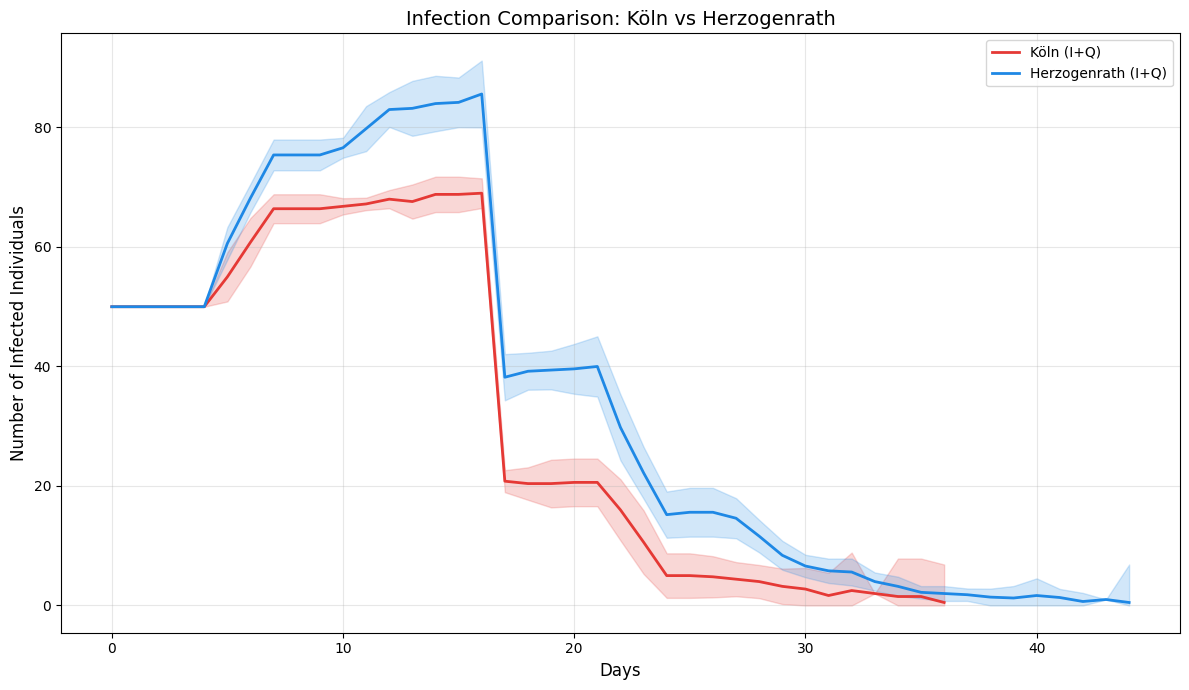

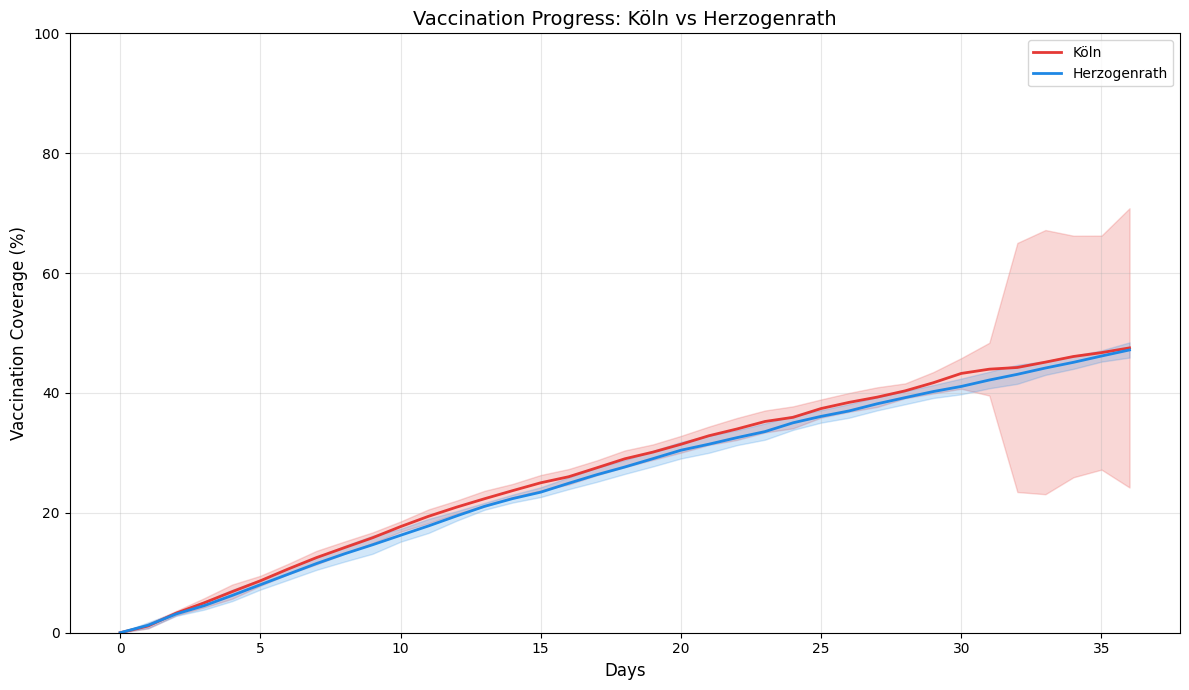

In [ ]:
# Compare Köln vs Herzogenrath

def plot_infection_comparison(koln_results, herzogenrath_results, output_file=None):
    """
    Plot comparison of infection rates between Köln and Herzogenrath.
    Handles different simulation termination times properly.
    
    Parameters:
    -----------
    koln_results : list of dict
        Analysis results for Köln
    herzogenrath_results : list of dict
        Analysis results for Herzogenrath
    output_file : str
        Path to save the figure (if None, just displays)
    """
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Define city styles 
    cities = [
        {"name": "Köln", "results": koln_results, "color": "#E53935"},  # Red
        {"name": "Herzogenrath", "results": herzogenrath_results, "color": "#1E88E5"}  # Blue
    ]
    
    # Find the maximum timestep across all simulations
    max_timestep = 0
    for city in cities:
        for result in city["results"]:
            time_steps = result["status_over_time"]["timestep"]
            max_timestep = max(max_timestep, max(time_steps))
    
    # Create a uniform time grid
    time_grid = np.arange(max_timestep + 1)
    
    # Process each city
    for city in cities:
        # Initialize arrays for tracking data
        infected_data = np.zeros((len(city["results"]), len(time_grid)))
        valid_counts = np.zeros(len(time_grid))
        
        # Fill infected data array (I+Q for SEIQRDV model)
        for i, result in enumerate(city["results"]):
            time_steps = result["status_over_time"]["timestep"]
            
            # Calculate total infected
            if result["model"] == "SEIQRDV":
                infected = [result["status_over_time"]["I"][idx] + result["status_over_time"]["Q"][idx] 
                           for idx in range(len(time_steps))]
            else:
                infected = result["status_over_time"]["I"]
            
            # Mark the last valid timestep for this run
            last_timestep = max(time_steps)
            
            # Fill data and mark valid counts
            for t_idx, t in enumerate(time_steps):
                if t < len(time_grid):
                    infected_data[i, t] = infected[t_idx]
                    valid_counts[t] += 1
            
            # Mark invalid data after simulation end
            infected_data[i, last_timestep+1:] = np.nan
        
        # Calculate statistics where we have valid data
        means = np.zeros(len(time_grid))
        lower = np.zeros(len(time_grid))
        upper = np.zeros(len(time_grid))
        
        for t in range(len(time_grid)):
            # Get valid data for this timestep
            valid_data = infected_data[:, t][~np.isnan(infected_data[:, t])]
            
            if len(valid_data) > 0:
                means[t] = np.mean(valid_data)
                
                if len(valid_data) > 1:
                    stdev = np.std(valid_data, ddof=1)
                    ci95 = stats.t.ppf(0.975, len(valid_data)-1) * stdev / np.sqrt(len(valid_data))
                    lower[t] = max(0, means[t] - ci95)
                    upper[t] = means[t] + ci95
                else:
                    lower[t] = means[t]
                    upper[t] = means[t]
            else:
                means[t] = np.nan
                lower[t] = np.nan
                upper[t] = np.nan
        
        # Find the last time step with enough valid data
        valid_threshold = max(2, len(city["results"]) // 2)  # At least 2 or half of runs
        reliable_timesteps = np.where(valid_counts >= valid_threshold)[0]
        
        if len(reliable_timesteps) > 0:
            last_reliable_t = reliable_timesteps[-1]
            plot_time_grid = time_grid[:last_reliable_t+1]
            plot_means = means[:last_reliable_t+1]
            plot_lower = lower[:last_reliable_t+1]
            plot_upper = upper[:last_reliable_t+1]
        else:
            plot_time_grid = time_grid
            plot_means = means
            plot_lower = lower
            plot_upper = upper
        
        # Plot with confidence intervals
        ax.plot(plot_time_grid, plot_means, 
                label=f"{city['name']} (I+Q)", 
                color=city["color"], 
                linewidth=2)
        
        ax.fill_between(plot_time_grid, plot_lower, plot_upper, 
                      alpha=0.2, 
                      color=city["color"])
    
    # Add labels and styling
    ax.set_xlabel("Days", fontsize=12)
    ax.set_ylabel("Number of Infected Individuals", fontsize=12)
    ax.set_title("Infection Comparison: Köln vs Herzogenrath", fontsize=14)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=10)
    
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
        print(f"Figure saved to {output_file}")
    
    return fig

def plot_simplified_vaccination_comparison(koln_results, herzogenrath_results, output_file=None):
    """
    Plot simplified comparison of vaccination progress between cities.
    Handles different simulation termination times properly.
    No 50% target lines or annotations.
    """
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Define city styles
    cities = [
        {"name": "Köln", "results": koln_results, "color": "#E53935"},  # Red
        {"name": "Herzogenrath", "results": herzogenrath_results, "color": "#1E88E5"}  # Blue
    ]
    
    # Find the maximum timestep across all simulations
    max_timestep = 0
    for city in cities:
        for result in city["results"]:
            time_steps = result["status_over_time"]["timestep"]
            max_timestep = max(max_timestep, max(time_steps))
    
    # Create a uniform time grid
    time_grid = np.arange(max_timestep + 1)
    
    # Track last reliable timestep for all cities
    all_last_reliable_ts = []
    city_data = {}
    
    # Process each city and collect data
    for city in cities:
        # Initialize arrays for tracking data
        vax_data = np.zeros((len(city["results"]), len(time_grid)))
        valid_counts = np.zeros(len(time_grid))
        
        # Fill vaccination data array
        for i, result in enumerate(city["results"]):
            time_steps = result["status_over_time"]["timestep"]
            values = result["status_over_time"]["V"]
            population = result["population"]
            
            # Convert to percentage
            values_pct = [100 * v / population for v in values]
            
            # Mark the last valid timestep for this run
            last_timestep = max(time_steps)
            
            # Fill data and mark valid counts
            for t_idx, t in enumerate(time_steps):
                if t < len(time_grid):
                    vax_data[i, t] = values_pct[t_idx]
                    valid_counts[t] += 1
            
            # Mark invalid data after simulation end
            vax_data[i, last_timestep+1:] = np.nan
        
        # Calculate statistics where we have valid data
        means = np.zeros(len(time_grid))
        lower = np.zeros(len(time_grid))
        upper = np.zeros(len(time_grid))
        
        for t in range(len(time_grid)):
            # Get valid data for this timestep
            valid_data = vax_data[:, t][~np.isnan(vax_data[:, t])]
            
            if len(valid_data) > 0:
                means[t] = np.mean(valid_data)
                
                if len(valid_data) > 1:
                    stdev = np.std(valid_data, ddof=1)
                    ci95 = stats.t.ppf(0.975, len(valid_data)-1) * stdev / np.sqrt(len(valid_data))
                    lower[t] = max(0, means[t] - ci95)
                    upper[t] = min(100, means[t] + ci95)
                else:
                    lower[t] = means[t]
                    upper[t] = means[t]
            else:
                means[t] = np.nan
                lower[t] = np.nan
                upper[t] = np.nan
        
        # Find the last time step with enough valid data
        valid_threshold = max(2, len(city["results"]) // 2)  # At least 2 or half of runs
        reliable_timesteps = np.where(valid_counts >= valid_threshold)[0]
        
        if len(reliable_timesteps) > 0:
            last_reliable_t = reliable_timesteps[-1]
            all_last_reliable_ts.append(last_reliable_t)
            
            # Store data for plotting
            city_data[city["name"]] = {
                "means": means,
                "lower": lower,
                "upper": upper,
                "last_reliable_t": last_reliable_t
            }
    
    # Find common cutoff point (earliest last reliable timestep)
    if all_last_reliable_ts:
        common_cutoff = min(all_last_reliable_ts)
        plot_time_grid = time_grid[:common_cutoff+1]
        
        # Plot each city's data up to common cutoff
        for city in cities:
            city_name = city["name"]
            if city_name in city_data:
                data = city_data[city_name]
                
                ax.plot(plot_time_grid, data["means"][:common_cutoff+1], 
                        label=city_name, 
                        color=city["color"], 
                        linewidth=2)
                
                ax.fill_between(plot_time_grid, 
                              data["lower"][:common_cutoff+1], 
                              data["upper"][:common_cutoff+1], 
                              alpha=0.2, 
                              color=city["color"])
    
    # Add labels and styling
    ax.set_xlabel("Days", fontsize=12)
    ax.set_ylabel("Vaccination Coverage (%)", fontsize=12)
    ax.set_title("Vaccination Progress: Köln vs Herzogenrath", fontsize=14)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=10)
    ax.set_ylim(0, 100)
    
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
        print(f"Figure saved to {output_file}")
    
    return fig


infection_comparison = plot_infection_comparison(
    koln_results=seiqrdv_full_results,
    herzogenrath_results=seiqrdv_herzogenrath_results,
    output_file="results/koln_vs_herzogenrath_infections.png"
)

# For vaccination comparison
vaccination_comparison = plot_simplified_vaccination_comparison(
    koln_results=seiqrdv_full_results,
    herzogenrath_results=seiqrdv_herzogenrath_results,
    output_file="results/koln_vs_herzogenrath_vaccination.png"
)


In [ ]:
scon.visualize_place_types_from_graphml("koln.graphmlz", "koln_config.json")

In [ ]:
scon.visualize_place_types_from_graphml("herzogenrath.graphmlz", "herzogenrath_config.json")